## Load Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase import io
import scipy
import matplotlib.pyplot as plt
import numpy as np

figure_fn = "data/spice-dipep-dipolar_val.xyz"
atomic_nums = []
for atm in io.iread(figure_fn):
    atomic_nums.append(atm.arrays["numbers"])
atomic_nums = np.hstack(atomic_nums)

#R2 scores -- validation set
def calc_r2(x,y):
    r = scipy.stats.pearsonr(x,y)[0]
    r2 = r**2
    return np.round(r2,3)

## Charges / Dipoles / Quads

In [3]:
charges, dipoles, quads, becs = {}, {}, {}, {}
typs = ['mbi', 'pred', 'hirsh', 'mul']
for d in [charges,dipoles,quads]:
    for typ in typs:
        d[typ] = []
dipoles["dft"] = []
quads["dft"] = []
becs["dft"], becs["pred"] = [], []
for atm in io.iread(figure_fn):
    for typ in typs:
        charges[typ].append(atm.arrays[f"{typ}_charges"])
        dipoles[typ].append(atm.info[f"{typ}_dipole"])
        quads[typ].append(atm.info[f"{typ}_quadrupole"])
    dipoles["dft"].append(atm.info["dipole"].squeeze())
    dft_quad = atm.info["quadrupole"].squeeze() - 1/3*atm.info["quadrupole"].squeeze().trace()*np.eye(3)
    quads["dft"].append(dft_quad)
    becs["dft"].append(atm.arrays["bec"].reshape(-1,3,3))
    becs["pred"].append(atm.arrays["pred_bec"].reshape(-1,3,3))
for d in [charges,dipoles,quads]:
    for typ in typs:
        d[typ] = np.hstack(d[typ])
dipoles["dft"] = np.hstack(dipoles["dft"])
quads["dft"] = np.hstack(quads["dft"])
becs["pred"] = np.vstack(becs["pred"])
becs["dft"] = np.vstack(becs["dft"])

import scipy
print("MBI vs. NN charges:",calc_r2(charges["pred"],charges["mbi"]))
print("#######################")
print("MBI vs. NN dipoles:",calc_r2(dipoles["pred"].ravel(),dipoles["mbi"].ravel()))
print("DFT vs. NN dipoles:",calc_r2(dipoles["pred"].ravel(),dipoles["dft"].ravel()))
print("DFT vs. MBI dipoles:",calc_r2(dipoles["mbi"].ravel(),dipoles["dft"].ravel()))
print("#######################")
print("MBI vs. NN quads:",calc_r2(quads["pred"].ravel(),quads["mbi"].ravel()))
print("DFT vs. NN quads:",calc_r2(quads["pred"].ravel(),quads["dft"].ravel()))
print("DFT vs. MBI quads:",calc_r2(quads["mbi"].ravel(),quads["dft"].ravel()))
print("#######################")
print("DFT vs. NN bec:",calc_r2(becs["pred"].ravel(),becs["dft"].ravel()))

MBI vs. NN charges: 0.859
#######################
MBI vs. NN dipoles: 0.976
DFT vs. NN dipoles: 0.987
DFT vs. MBI dipoles: 0.995
#######################
MBI vs. NN quads: 0.975
DFT vs. NN quads: 0.91
DFT vs. MBI quads: 0.922
#######################
DFT vs. NN bec: 0.943


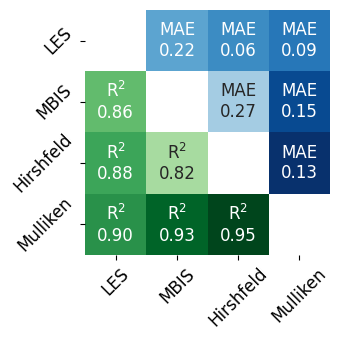

In [4]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(charges)
df = df.rename({"pred":"LES","hirsh":"Hirshfeld","mbi":"MBIS","mul":"Mulliken"},axis="columns")
df = df.loc[:,["LES","MBIS","Hirshfeld","Mulliken"]]
r2 = df.corr()**2
r22 = r2.copy()
for i,col1 in enumerate(r2.columns):
    for j,col2 in enumerate(r2.columns):
        if j > i:
            mae = np.round(np.abs(df[col1] - df[col2]).mean(),2)
            r2.loc[col1,col2] = f"MAE\n{mae:.2f}"
        else:
            d = np.round(r2.loc[col1,col2],2)
            r2.loc[col1,col2] = f"R$^2$\n{d:.2f}"
plt.subplots(figsize=(4,3.5))
plt.gca().set_aspect('equal')

mask1 = np.zeros_like(r2)
mask2 = np.zeros_like(r2)
mask1[np.tril_indices_from(r2)] = True
mask2[np.triu_indices_from(r2)] = True

vmin, vmax = 0.75,0.95
ax1 = sns.heatmap(r22,mask=mask2,annot=np.array(r2),cmap='Greens',vmin=vmin,vmax=vmax,
            cbar=False,annot_kws={"size": 12},fmt = '')
sns.heatmap(r22,mask=mask1,annot=np.array(r2),cmap='Blues',vmin=vmin,vmax=vmax,
            cbar=False,annot_kws={"size": 12},fmt = '',ax=ax1)

tcks = [0.5,1.5,2.5,3.5]
tcks2 = ["LES","MBIS","Hirshfeld","Mulliken"]
plt.xticks(tcks,tcks2,fontsize=12,rotation=45)
plt.yticks(tcks,tcks2,fontsize=12,rotation=45)
plt.tight_layout()
plt.savefig("figures/charges_r2.pdf",format='pdf',dpi=500)

## Charges

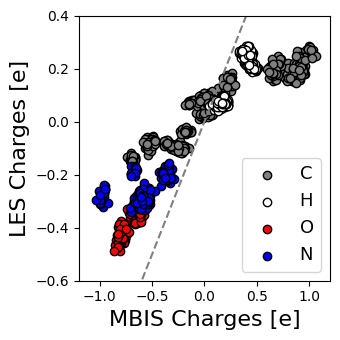

In [5]:
fs=16
djvfont = {'fontname':'DejaVu Sans'}
eltrans = {1:"H",6:"C",7:"N",8:"O"}
colors = {1:"white",6:"grey",7:"blue",8:"red"}
plt.subplots(figsize=(3.5,3.5))
mbi_charges = np.array(charges["mbi"])
nn_charges = np.array(charges["pred"])
for el in [6,1,8,7]:
    idx = np.where(atomic_nums == el)[0]
    mbi = mbi_charges[idx]
    nnc = nn_charges[idx]
    plt.scatter(mbi,nnc,label=eltrans[el],color=colors[el],edgecolors='black')
xmin, xmax = -1.25,1.26
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(-1.2,1.2)
plt.ylim(-0.6,0.4)
s = 0.5
plt.xlabel("MBIS Charges [e]",fontsize=fs,**djvfont)
plt.ylabel("LES Charges [e]",fontsize=fs,**djvfont)
plt.legend(loc="lower right",prop={'family':'DejaVu Sans', 'size':fs-3})
# plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/les_vs_mbi_val.pdf",format='pdf',dpi=500)

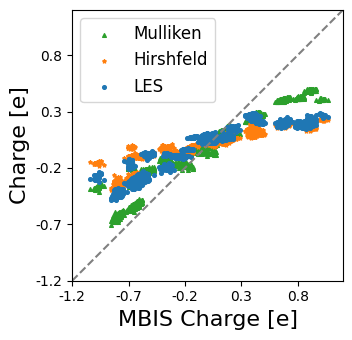

In [6]:
import numpy as np
df = charges
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.subplots(figsize=(4,3.5))
from dsk.pickle import load_pkl, dump_pkl
df = pd.DataFrame(charges)
size = 7
plt.scatter(df["mbi"],df["mul"],label="Mulliken",marker="^",s=size,c="tab:green")
plt.scatter(df["mbi"],df["hirsh"],label="Hirshfeld",marker="*",s=size,c="tab:orange")
plt.scatter(df["mbi"],df["pred"],label="LES",marker="o",s=size,c="tab:blue")
s = 0.5
xmin, xmax = -1.2,1.2
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xticks(np.round(np.arange(xmin,xmax,s),2),np.round(np.arange(xmin,xmax,s),2))
plt.yticks(np.round(np.arange(xmin,xmax,s),2),np.round(np.arange(xmin,xmax,s),2))
plt.legend(loc="upper left",prop={'size': 12})
# plt.title("Charge Comparison",fontsize=fs,**djvfont)
plt.xlabel("MBIS Charge [e]",fontsize=fs,**djvfont)
plt.ylabel("Charge [e]",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/charge_comparison.pdf",format='pdf',dpi=500)

## Dipole Moments

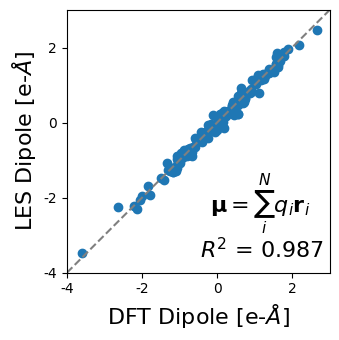

In [7]:
djvfont = {'fontname':'DejaVu Sans'}
plt.subplots(figsize=(4,3.5))
xdata, ydata = dipoles["dft"].ravel(),dipoles["pred"].ravel()
r2 = calc_r2(xdata,ydata)
plt.scatter(xdata,ydata)
fs=16
plt.xlabel("DFT Dipole [e-$\AA$]",fontsize=fs,**djvfont)
plt.ylabel("LES Dipole [e-$\AA$]",fontsize=fs,**djvfont)
xmin, xmax = -4,3
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
s = 2
plt.xticks(np.arange(xmin,xmax,s),np.arange(xmin,xmax,s))
plt.yticks(np.arange(xmin,xmax,s),np.arange(xmin,xmax,s))
plt.text(-0.2,-2.4,"$\mathbf{\mu} = \sum_i^N q_i \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.text(-0.45,-3.6,f"$R^2$ = {r2}",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/dipoles_dft_les_val.pdf",format='pdf',dpi=500)

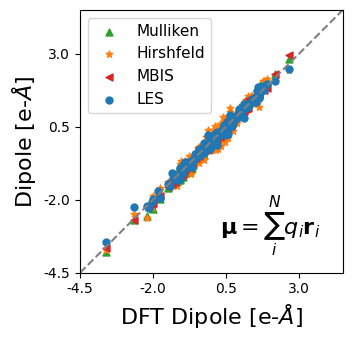

In [8]:
import numpy as np
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.subplots(figsize=(4,3.5))
from dsk.pickle import load_pkl, dump_pkl
size = 25
plt.scatter(dipoles["dft"],dipoles["mul"],label="Mulliken",marker="^",s=size,c="tab:green")
plt.scatter(dipoles["dft"],dipoles["hirsh"],label="Hirshfeld",marker="*",s=size,c="tab:orange")
plt.scatter(dipoles["dft"],dipoles["mbi"],label="MBIS",marker="<",s=size,c="tab:red")
plt.scatter(dipoles["dft"],dipoles["pred"],label="LES",marker="o",s=size,c="tab:blue")
s = 2.5
xmin, xmax = -4.5,4.5
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xticks(np.round(np.arange(xmin,xmax,s),2),np.round(np.arange(xmin,xmax,s),2))
plt.yticks(np.round(np.arange(xmin,xmax,s),2),np.round(np.arange(xmin,xmax,s),2))
plt.legend(loc="upper left",prop={'size': 11})
plt.xlabel("DFT Dipole [e-$\AA$]",fontsize=fs,**djvfont)
plt.ylabel("Dipole [e-$\AA$]",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.text(0.3,-3.2,"$\mathbf{\mu} = \sum_i^N q_i \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.tight_layout()
plt.savefig("figures/dipole_comparison.pdf",format='pdf',dpi=500)

## Quadrupoles

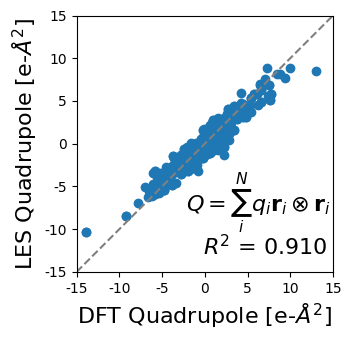

In [9]:
djvfont = {'fontname':'DejaVu Sans'}
plt.subplots(figsize=(4,3.5))
xdata, ydata = quads["dft"].ravel(),quads["pred"].ravel()
r2 = calc_r2(xdata,ydata)
plt.scatter(xdata,ydata)
fs=16
plt.xlabel("DFT Quadrupole [e-$\AA^2$]",fontsize=fs,**djvfont)
plt.ylabel("LES Quadrupole [e-$\AA^2$]",fontsize=fs,**djvfont)
xmin, xmax = -15,15
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
s = 5
plt.xticks(np.arange(xmin,xmax+1,s),np.arange(xmin,xmax+1,s))
plt.yticks(np.arange(xmin,xmax+1,s),np.arange(xmin,xmax+1,s))
plt.text(-2.2,-8,"$Q = \sum_i^N q_i \mathbf{r}_{i} \otimes \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.text(-0.2,-13,f"$R^2$ = {r2}0",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/quads_dft_les_val.pdf",format='pdf',dpi=500)

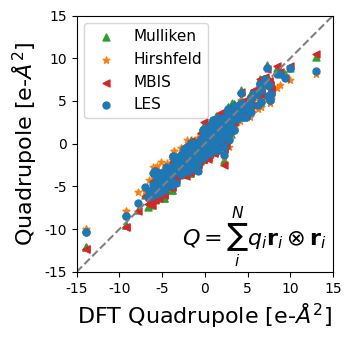

In [10]:
import numpy as np
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.subplots(figsize=(4,3.5))
from dsk.pickle import load_pkl, dump_pkl
size = 25
plt.scatter(quads["dft"],quads["mul"],label="Mulliken",marker="^",s=size,c="tab:green")
plt.scatter(quads["dft"],quads["hirsh"],label="Hirshfeld",marker="*",s=size,c="tab:orange")
plt.scatter(quads["dft"],quads["mbi"],label="MBIS",marker="<",s=size,c="tab:red")
plt.scatter(quads["dft"],quads["pred"],label="LES",marker="o",s=size,c="tab:blue")
xmin, xmax = -15, 15
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
s = 5
plt.xticks(np.arange(xmin,xmax+1,s),np.arange(xmin,xmax+1,s))
plt.yticks(np.arange(xmin,xmax+1,s),np.arange(xmin,xmax+1,s))
plt.legend(loc="upper left",prop={'size': 11})
plt.xlabel("DFT Quadrupole [e-$\AA^2$]",fontsize=fs,**djvfont)
plt.ylabel("Quadrupole [e-$\AA^2$]",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.text(-2.7,-12,"$Q = \sum_i^N q_i \mathbf{r}_{i} \otimes \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.tight_layout()
plt.savefig("figures/quadrupole_comparison.pdf",format='pdf',dpi=500)

## BEC

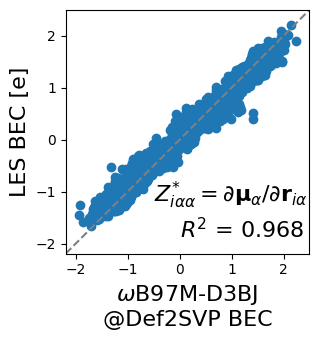

In [11]:
import torch
def get_diag(arr,diag=True):
    arr = torch.tensor(arr)
    mask = torch.zeros_like(arr)
    mv = torch.diagonal(mask,dim1=1,dim2=2)
    mv += 1
    if diag:
        return arr[mask.bool()].numpy()
    else:
        return arr[~mask.bool()].numpy()

import scipy
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.subplots(figsize=(4,3.5))
diag = True
truex = get_diag(becs["dft"],diag=diag)
predx = get_diag(becs["pred"],diag=diag)
xmin = min(np.min(truex),np.min(predx)) - 0.25
xmax = max(np.max(truex),np.max(predx)) + 0.25
arr = np.arange(xmin,xmax,0.01)
r = scipy.stats.pearsonr(truex.ravel(),predx.ravel())[0]
r2 = np.round(r**2,3)
plt.xlabel("$\omega$B97M-D3BJ\n@Def2SVP BEC",fontsize=fs,**djvfont)
plt.ylabel("LES BEC [e]",fontsize=fs,**djvfont)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.scatter(truex,predx)
plt.plot(arr,arr,linestyle="--",color="grey")
plt.text(-0.5,-1.2,"$Z_{i \\alpha \\alpha}^{*} = \partial \mathbf{\mu}_\\alpha/\partial{\mathbf{r}_{i\\alpha}}$",fontsize=fs,**djvfont)
plt.text(0,-1.9,f"$R^2$ = {r2}",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/diagonal_bec_val.pdf",format='pdf',dpi=500)

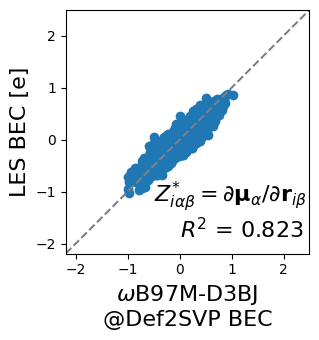

In [12]:
import scipy
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.subplots(figsize=(4,3.5))
diag = False
truex = get_diag(becs["dft"],diag=diag)
predx = get_diag(becs["pred"],diag=diag)
xmin = -2.190323031838511
xmax = 2.49442159708481
arr = np.arange(xmin,xmax,0.01)
r = scipy.stats.pearsonr(truex.ravel(),predx.ravel())[0]
r2 = np.round(r**2,3)
plt.xlabel("$\omega$B97M-D3BJ\n@Def2SVP BEC",fontsize=fs,**djvfont)
plt.ylabel("LES BEC [e]",fontsize=fs,**djvfont)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.scatter(truex,predx)
plt.plot(arr,arr,linestyle="--",color="grey")
plt.text(-0.5,-1.2,"$Z_{i \\alpha \\beta}^{*} = \partial \mathbf{\mu}_\\alpha/\partial{\mathbf{r}_{i\\beta}}$",fontsize=fs,**djvfont)
plt.text(0,-1.9,f"$R^2$ = {r2}",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/nondiagonal_bec_val.pdf",format='pdf',dpi=500)